# Libraries

In [51]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
from geopy import distance
import plotly.express as px
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
pd.set_option('display.max_columns', 500)
sns.set(style="whitegrid", palette="pastel", color_codes=True)


sys.path.append("../")
from src.utils.etl.pipeline import transform

n_partitions=16
geolocator = Nominatim(user_agent="GoogleV3")

In [52]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [53]:
if True:
    df = pd.read_csv('../data/raw/properati_a_predecir.csv')
    df = transform(df, n_partitions)
    df.to_parquet('../data/interim/df_test_eda.parquet', engine='pyarrow')
else:
    df= pd.read_parquet('../data/interim/df_test_eda.parquet', engine='pyarrow')

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df.head(2)

,id,ad_type,lat,lon,country,province,suburb,published_suburb,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,556713,Propiedad,-34.573623,-58.442399,Argentina,Ciudad Autonoma de Buenos Aires,Colegiales,None,3.0,2.0,2.0,NaN,NaN,NaN,USD,departamento venta belgrano capital federal,sup escritura 96.47 m2 cubiertos 61 m2 descubi...,Departamento,Venta
1,192912,Propiedad,-34.606620,-58.430493,Argentina,Ciudad Autonoma de Buenos Aires,Almagro,None,3.0,2.0,2.0,77.0,67.0,NaN,USD,departamento 3 ambientes venta almagro,excelente departamento ambientes amplio modern...,Departamento,Venta


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                6000 non-null   int64  
 1   ad_type           6000 non-null   object 
 2   lat               5544 non-null   float64
 3   lon               5544 non-null   float64
 4   country           6000 non-null   object 
 5   province          6000 non-null   object 
 6   suburb            5789 non-null   object 
 7   published_suburb  459 non-null    object 
 8   rooms             6000 non-null   float64
 9   bedrooms          4932 non-null   float64
 10  bathrooms         5782 non-null   float64
 11  surface_total     4776 non-null   float64
 12  surface_covered   4879 non-null   float64
 13  price             0 non-null      float64
 14  currency          6000 non-null   object 
 15  title             6000 non-null   object 
 16  description       6000 non-null   object 


In [ ]:
df.isna().sum() / len(df)

id                  0.000000
ad_type             0.000000
lat                 0.076000
lon                 0.076000
country             0.000000
province            0.000000
suburb              0.035167
published_suburb    0.923500
rooms               0.000000
bedrooms            0.178000
bathrooms           0.036333
surface_total       0.204000
surface_covered     0.186833
price               1.000000
currency            0.000000
title               0.000000
description         0.000000
property_type       0.000000
operation_type      0.000000
dtype: float64

In [ ]:
df = df.drop(["price"], axis=1)

In [ ]:
cat_cols = 'ad_type currency property_type operation_type country province'.split()
num_cols = 'surface_total surface_covered bathrooms bedrooms'.split()

In [ ]:
# potential usful cols: price_usd_per_m2 price_per_m2

## Graph Viz

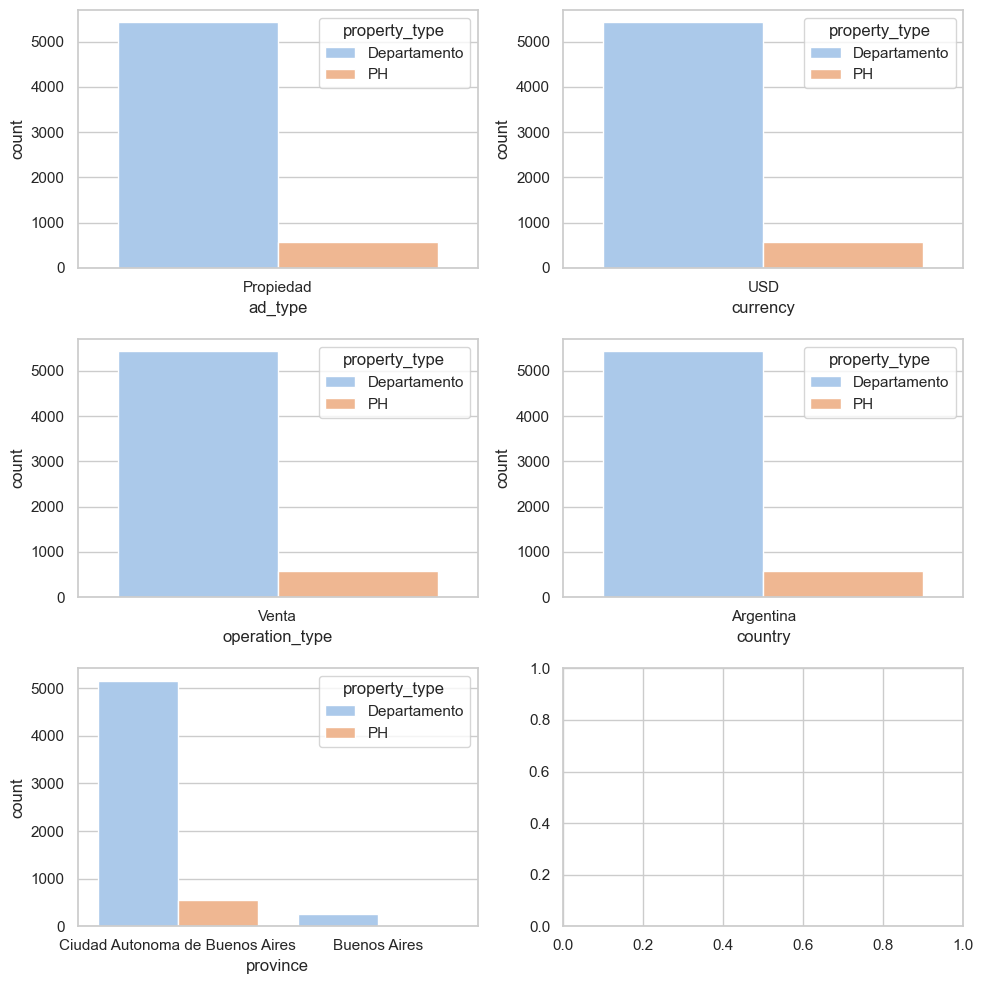

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes = axes.flat

hue='property_type'
cat_cols_temp = cat_cols.copy()
cat_cols_temp.remove(hue)

for i,col in enumerate(cat_cols_temp):
    sns.countplot(x=col, data=df.fillna("Missing"), ax=axes[i], hue=hue)
plt.tight_layout()
plt.show()

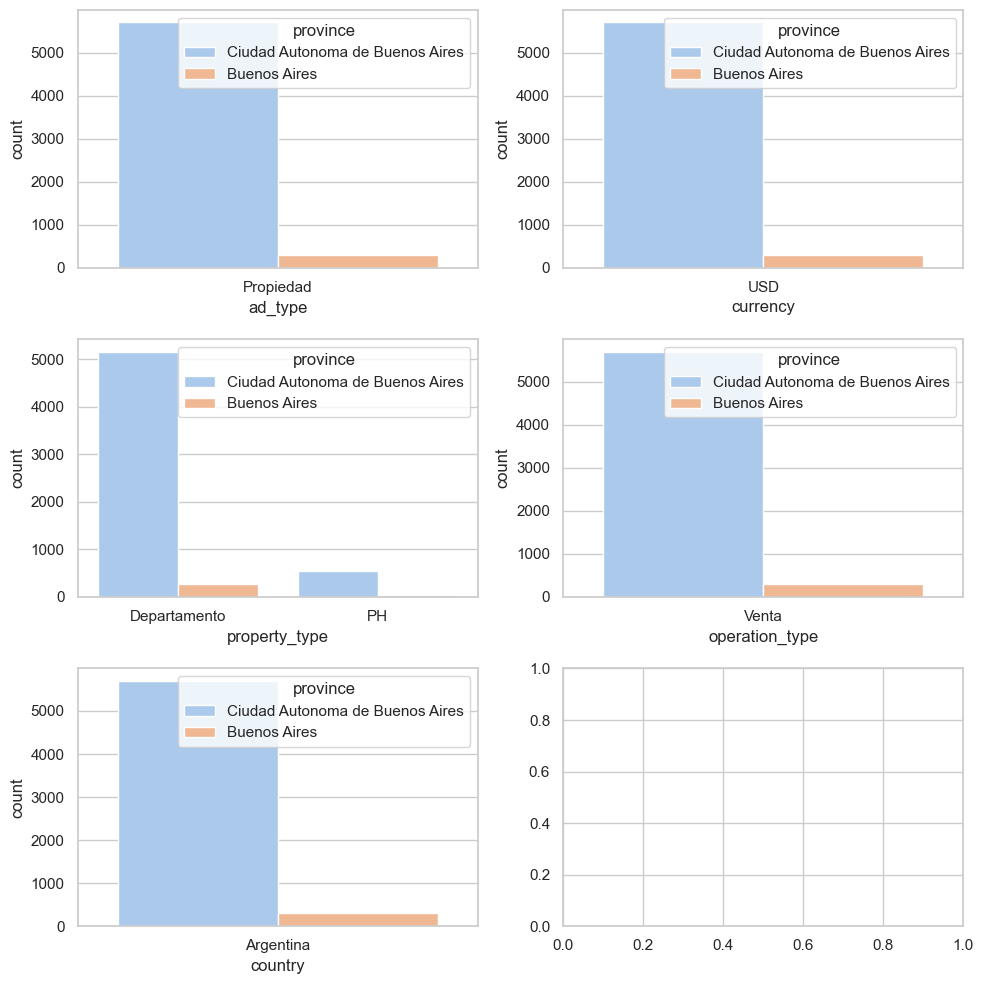

In [ ]:
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes = axes.flat

hue='province'
cat_cols_temp = cat_cols.copy()
cat_cols_temp.remove(hue)

for i,col in enumerate(cat_cols_temp):
    sns.countplot(x=col, data=df.fillna("Missing"), ax=axes[i], hue=hue)
plt.tight_layout()
plt.show()

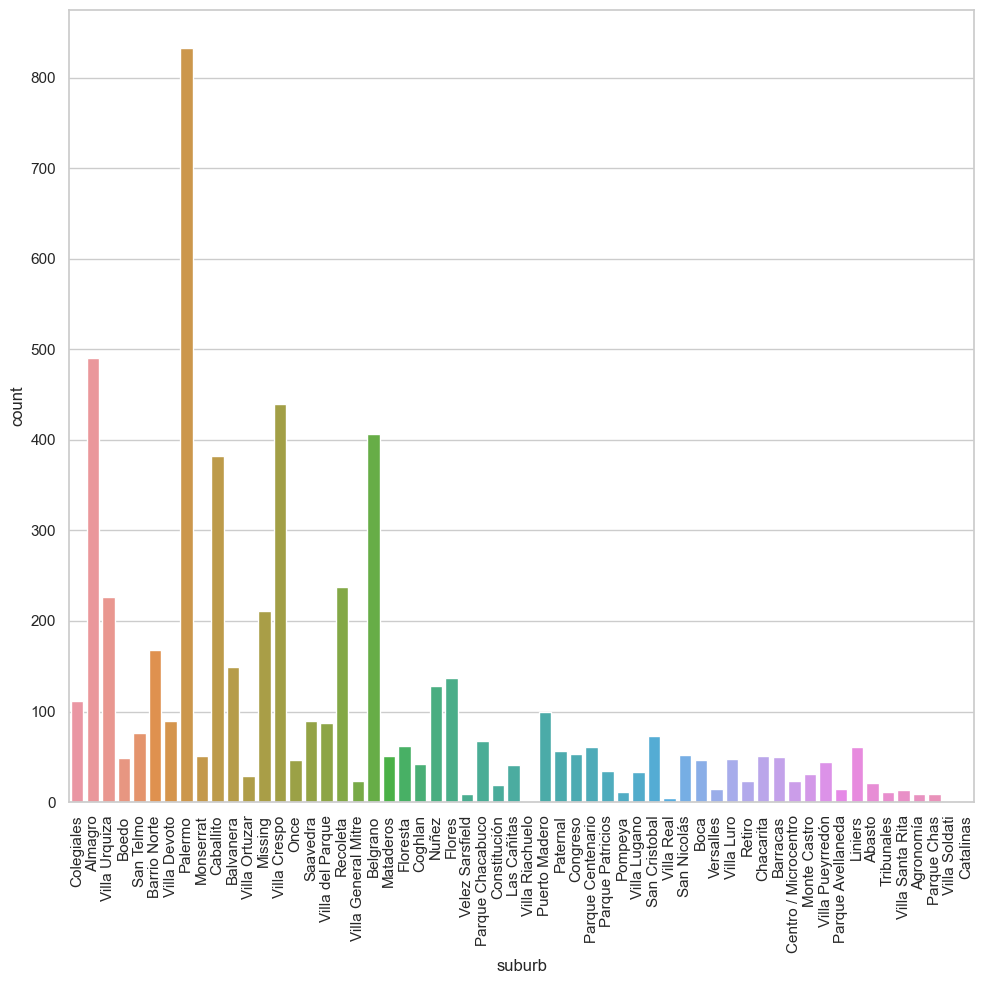

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x='suburb', data=df[df["province"]==  "Ciudad Autonoma de Buenos Aires"].fillna("Missing"))

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

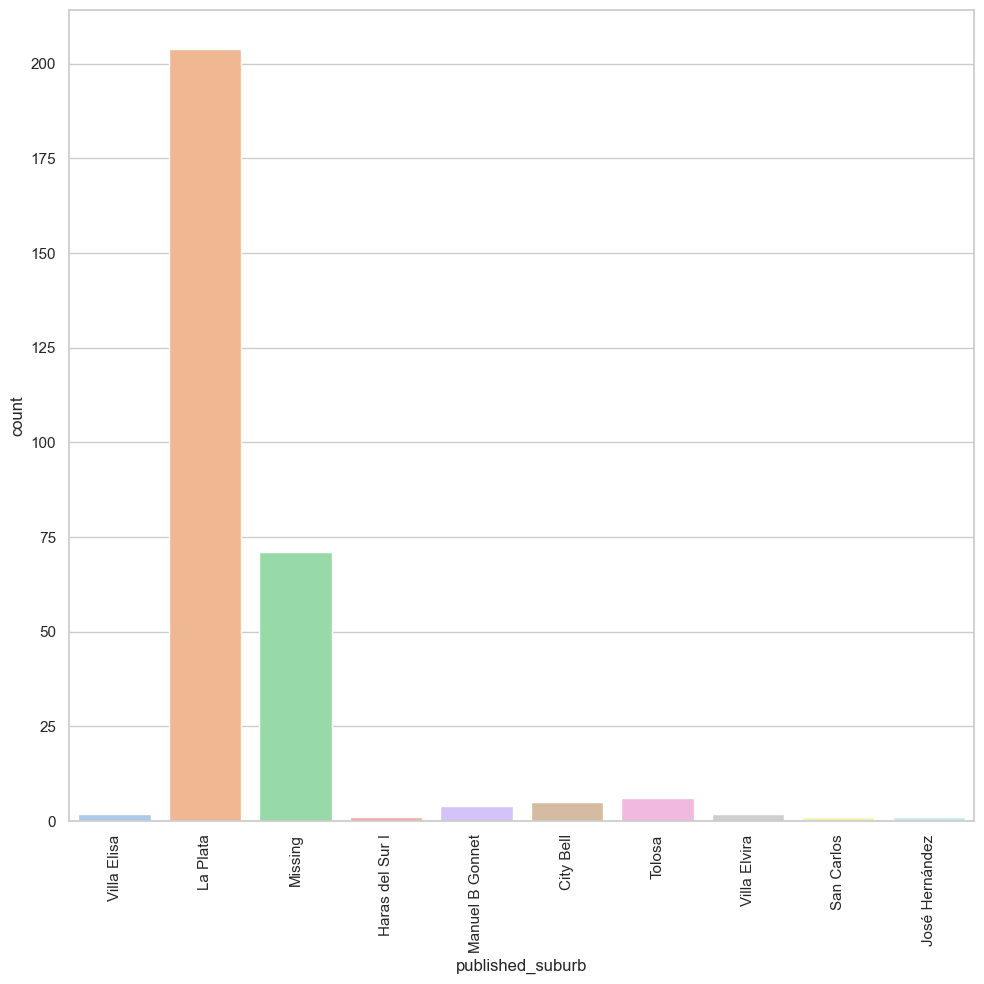

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x='published_suburb', data=df[df["province"]=="Buenos Aires"].fillna("Missing"))

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

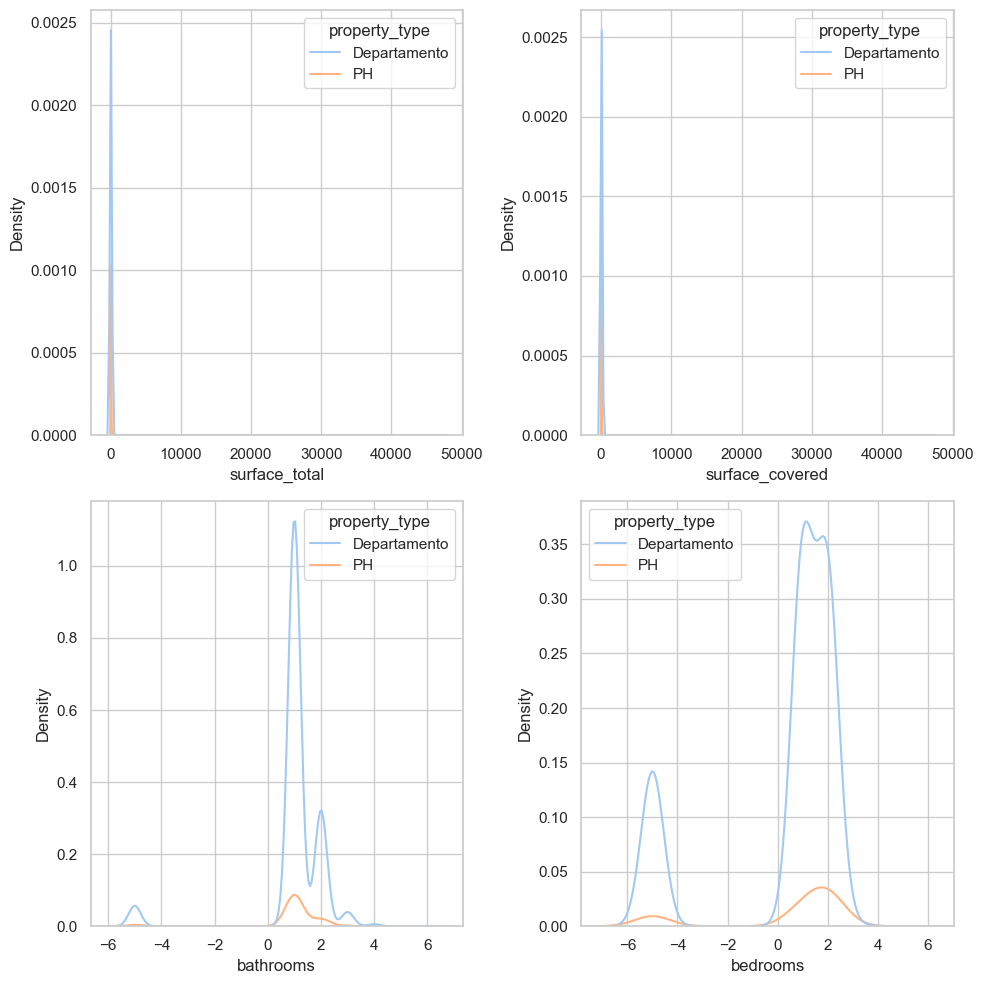

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

axes = axes.flat

hue='property_type'
cat_cols_temp = cat_cols.copy()
cat_cols_temp.remove(hue)

for i,col in enumerate(num_cols):
    sns.kdeplot(x=col, data=df.fillna(-5), ax=axes[i], hue=hue)

plt.tight_layout()
plt.show()

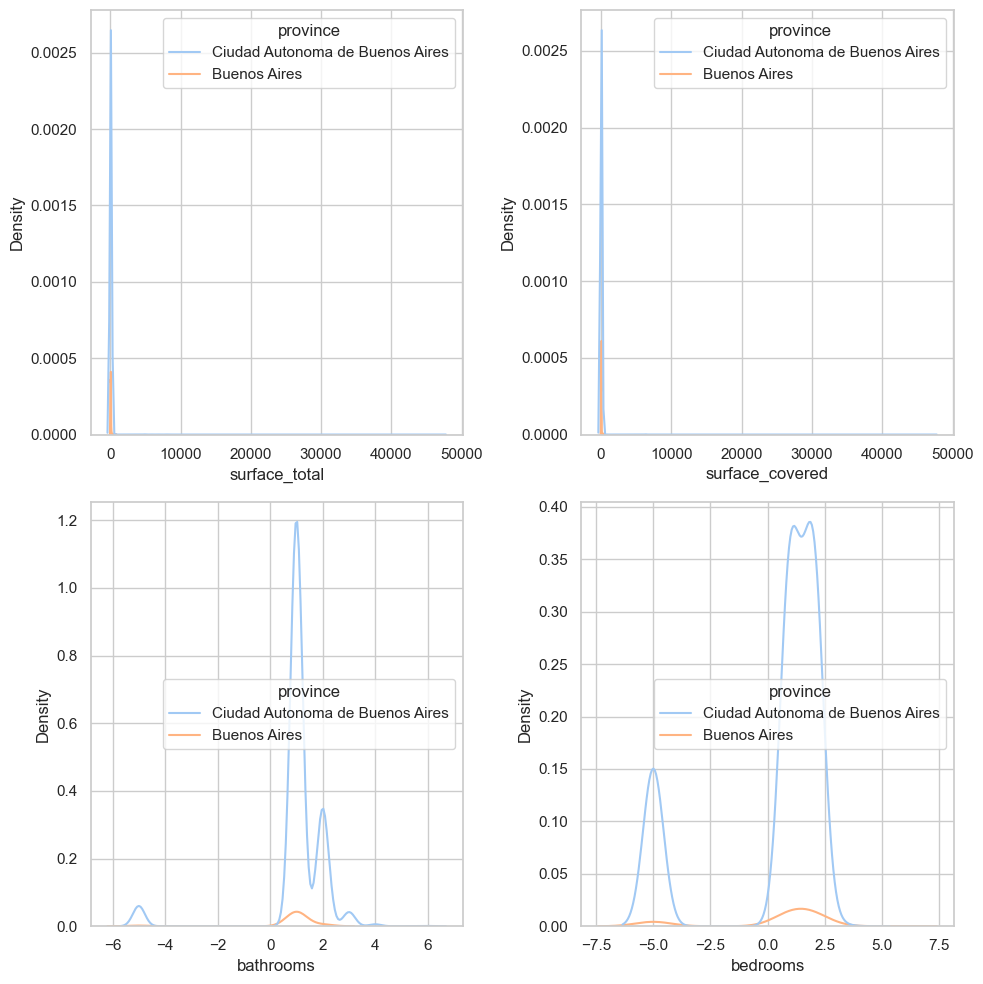

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

axes = axes.flat

hue='province'
cat_cols_temp = cat_cols.copy()
cat_cols_temp.remove(hue)

for i,col in enumerate(num_cols):
    sns.kdeplot(x=col, data=df.fillna(-5), ax=axes[i], hue=hue)

plt.tight_layout()
plt.show()

In [ ]:
df.describe(include='all')

,id,ad_type,lat,lon,country,province,suburb,published_suburb,rooms,bedrooms,bathrooms,surface_total,surface_covered,currency,title,description,property_type,operation_type
count,6000.00000,6000,5544.000000,5544.000000,6000,6000,5789,459,6000.000000,4932.000000,5782.000000,4776.000000,4879.000000,6000,6000,6000,6000,6000
unique,NaN,1,NaN,NaN,1,2,58,13,NaN,NaN,NaN,NaN,NaN,1,3870,5093,2,1
top,NaN,Propiedad,NaN,NaN,Argentina,Ciudad Autonoma de Buenos Aires,Palermo,La Plata,NaN,NaN,NaN,NaN,NaN,USD,departamento 2 ambientes venta villa crespo,excelente monoambiente divisible contrafrente ...,Departamento,Venta
freq,NaN,6000,NaN,NaN,6000,5703,833,204,NaN,NaN,NaN,NaN,NaN,6000,143,15,5426,6000
mean,460802.42000,NaN,-34.598136,-58.445369,NaN,NaN,NaN,NaN,2.502667,1.510138,1.275683,91.936558,77.377126,NaN,NaN,NaN,NaN,NaN
std,282441.51075,NaN,0.239306,0.465452,NaN,NaN,NaN,NaN,0.500035,0.512764,0.531740,842.190048,746.081221,NaN,NaN,NaN,NaN,NaN
min,114.00000,NaN,-40.156235,-71.345241,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,10.000000,21.000000,NaN,NaN,NaN,NaN,NaN
25%,219797.50000,NaN,-34.616927,-58.460256,NaN,NaN,NaN,NaN,2.000000,1.000000,1.000000,48.000000,43.000000,NaN,NaN,NaN,NaN,NaN
50%,450422.00000,NaN,-34.600578,-58.433935,NaN,NaN,NaN,NaN,3.000000,2.000000,1.000000,60.000000,54.000000,NaN,NaN,NaN,NaN,NaN
75%,674144.00000,NaN,-34.583791,-58.410085,NaN,NaN,NaN,NaN,3.000000,2.000000,1.000000,79.000000,68.000000,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = df.copy()

color_scale = [(0, 'orange'), (1,'red')]

fig = None
fig = px.scatter_mapbox(df,
                        lat="lat",
                        lon="lon",
                        hover_name="title",
                        hover_data=["id", "suburb", "published_suburb"],
                        color="province",
                        color_continuous_scale=color_scale,
                        zoom=10,
                        height=800,
                        width=1600)

fig.update_layout(mapbox_style="carto-darkmatter")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()